# Exploratory Data Analysis of the Voice Recognition Dataset

This notebook performs comprehensive EDA on the voice recognition dataset, including:
1. Initial EDA on full audio files (before segmentation)
2. Feature extraction and analysis
3. EDA on segmented audio and spectrograms

In [1]:
# Setup and Imports
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
try:
    import parselmouth
    HAS_PARSELMOUTH = True
except ImportError:
    HAS_PARSELMOUTH = False
    print("Warning: parselmouth not installed. HNR features will be skipped.")
import scipy as sp
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set up paths
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
CUSTOM_DATASET_DIR = DATA_DIR / "custom_dataset"
METADATA_PATH = CUSTOM_DATASET_DIR / "metadata.csv"
AUDIO_DIR = CUSTOM_DATASET_DIR / "audio"
SPECTROGRAM_DIR = CUSTOM_DATASET_DIR / "spectrograms"
FULL_AUDIO_DIR = DATA_DIR / "full_audio_files"

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Initial EDA on Full Audio (Before Segmentation)

In [14]:
# Load metadata
metadata_df = pd.read_csv(METADATA_PATH) if METADATA_PATH.exists() else pd.DataFrame()
print(f"Metadata shape: {metadata_df.shape}")
if not metadata_df.empty:
    print(f"Metadata columns: {metadata_df.columns.tolist()}")
    print(f"Metadata head:\n{metadata_df.head()}")
else:
    print("Metadata file is empty or doesn't exist")


Metadata shape: (479, 3)
Metadata columns: ['file_name', 'label', 'place']
Metadata head:
                file_name   label          place
0  DoorIntheWall_0000.wav  reject  DoorIntheWall
1  DoorIntheWall_0001.wav  reject  DoorIntheWall
2  DoorIntheWall_0002.wav  reject  DoorIntheWall
3  DoorIntheWall_0003.wav  reject  DoorIntheWall
4  DoorIntheWall_0004.wav  reject  DoorIntheWall


In [15]:
# Function to load full audio files
def load_full_audio_files(audio_dir, metadata_df=None, sr=16000):
    """
    Load full audio files from directory structure.
    Expected structure: audio_dir/accept/ and audio_dir/reject/ subdirectories
    """
    audio_data = []
    audio_extensions = {'.wav', '.mp3', '.flac', '.m4a', '.ogg'}
    
    if not audio_dir.exists():
        print(f"Audio directory not found: {audio_dir}")
        return audio_data
    
    # Check if metadata exists and has file_name column
    has_metadata = not metadata_df.empty and 'file_name' in metadata_df.columns
    
    # Try to find audio files in subdirectories (accept/reject structure)
    for subdir in audio_dir.iterdir():
        if subdir.is_dir():
            label = subdir.name  # accept or reject
            for audio_file in subdir.rglob('*'):
                if audio_file.suffix.lower() in audio_extensions:
                    try:
                        y, sample_rate = librosa.load(str(audio_file), sr=sr)
                        file_name = audio_file.name
                        
                        # Try to get metadata for this file
                        metadata_row = None
                        if has_metadata:
                            matching_rows = metadata_df[metadata_df['file_name'] == file_name]
                            if not matching_rows.empty:
                                metadata_row = matching_rows.iloc[0].to_dict()
                        
                        audio_data.append({
                            'file_path': str(audio_file),
                            'file_name': file_name,
                            'label': label,
                            'audio': y,
                            'sr': sample_rate,
                            'duration': len(y) / sample_rate,
                            'metadata': metadata_row
                        })
                        print(f"Loaded: {file_name} ({label}) - {len(y)/sample_rate:.2f}s")
                    except Exception as e:
                        print(f"Failed to load {audio_file}: {e}")
    
    # If no subdirectories found, try loading directly from audio_dir
    if not audio_data:
        for audio_file in audio_dir.rglob('*'):
            if audio_file.suffix.lower() in audio_extensions:
                try:
                    y, sample_rate = librosa.load(str(audio_file), sr=sr)
                    file_name = audio_file.name
                    
                    # Try to get label from metadata or filename
                    label = 'unknown'
                    metadata_row = None
                    if has_metadata:
                        matching_rows = metadata_df[metadata_df['file_name'] == file_name]
                        if not matching_rows.empty:
                            metadata_row = matching_rows.iloc[0].to_dict()
                            label = metadata_row.get('label', 'unknown')
                    
                    audio_data.append({
                        'file_path': str(audio_file),
                        'file_name': file_name,
                        'label': label,
                        'audio': y,
                        'sr': sample_rate,
                        'duration': len(y) / sample_rate,
                        'metadata': metadata_row
                    })
                    print(f"Loaded: {file_name} ({label}) - {len(y)/sample_rate:.2f}s")
                except Exception as e:
                    print(f"Failed to load {audio_file}: {e}")
    
    print(f"\n{'='*50}")
    print(f"Loaded {len(audio_data)} audio file(s)")
    print(f"{'='*50}")
    return audio_data

# Load full audio files
full_audio_data = load_full_audio_files(FULL_AUDIO_DIR, metadata_df)


Loaded: laptop1_Nischa.mp3 (accept) - 60.74s
Loaded: egecan.mp3 (accept) - 1399.06s
Loaded: IMG_4858.mp3 (accept) - 45.05s
Loaded: audio_2025-11-16_09-46-36.mp3 (accept) - 109.10s
Loaded: IMG_4849.mp3 (accept) - 33.27s
Loaded: audio_2025-11-16_09-46-32.mp3 (accept) - 52.37s
Loaded: audio_2025-11-16_09-46-26.mp3 (accept) - 338.05s
Loaded: IMG_4848.mp3 (accept) - 57.98s
Loaded: laptop1_Marques_Brownlee.mp3 (accept) - 60.61s
Loaded: Matt_Davella_1.mp3 (accept) - 60.91s
Loaded: Samuel L. Jackson laptop.m4a (accept) - 58.20s
Loaded: Matt_Davella_2.mp3 (accept) - 60.10s
Loaded: audio_2025-11-16_09-46-40.mp3 (accept) - 161.22s
Loaded: Natalie Portman.m4a (accept) - 89.86s
Loaded: audio_2025-11-16_09-46-55.mp3 (accept) - 149.40s
Loaded: Matt_Davella_3.mp3 (accept) - 52.84s
Loaded: audio_2025-11-16_09-47-01.mp3 (accept) - 257.83s
Loaded: Samuel L Jackson laptop (3).m4a (accept) - 47.02s
Loaded: Samuel L Jackson laptop (2).m4a (accept) - 41.98s
Loaded: audio_2025-11-16_09-46-51.mp3 (accept) - 10

In [16]:
# Create summary DataFrame for full audio
if full_audio_data:
    full_audio_summary = []
    for item in full_audio_data:
        summary = {
            'file_name': item['file_name'],
            'label': item['label'],
            'duration': item['duration'],
            'file_path': item['file_path']
        }
        # Add metadata if available (only place, since gender/age/duration_s were removed)
        if item['metadata']:
            if 'place' in item['metadata']:
                summary['place'] = item['metadata']['place']
        full_audio_summary.append(summary)
    
    full_audio_df = pd.DataFrame(full_audio_summary)
    print("Full Audio Summary:")
    print(full_audio_df.head())
    print(f"\nShape: {full_audio_df.shape}")
else:
    print("No full audio files found. Please ensure audio files are in data/full_audio_files/")
    full_audio_df = pd.DataFrame()


Full Audio Summary:
                       file_name   label     duration  \
0             laptop1_Nischa.mp3  accept    60.736000   
1                     egecan.mp3  accept  1399.060000   
2                   IMG_4858.mp3  accept    45.045313   
3  audio_2025-11-16_09-46-36.mp3  accept   109.098687   
4                   IMG_4849.mp3  accept    33.272750   

                                           file_path    place  
0  ../data/full_audio_files/accept/laptop1_Nischa...  unknown  
1         ../data/full_audio_files/accept/egecan.mp3  unknown  
2       ../data/full_audio_files/accept/IMG_4858.mp3  unknown  
3  ../data/full_audio_files/accept/audio_2025-11-...  unknown  
4       ../data/full_audio_files/accept/IMG_4849.mp3  unknown  

Shape: (479, 5)


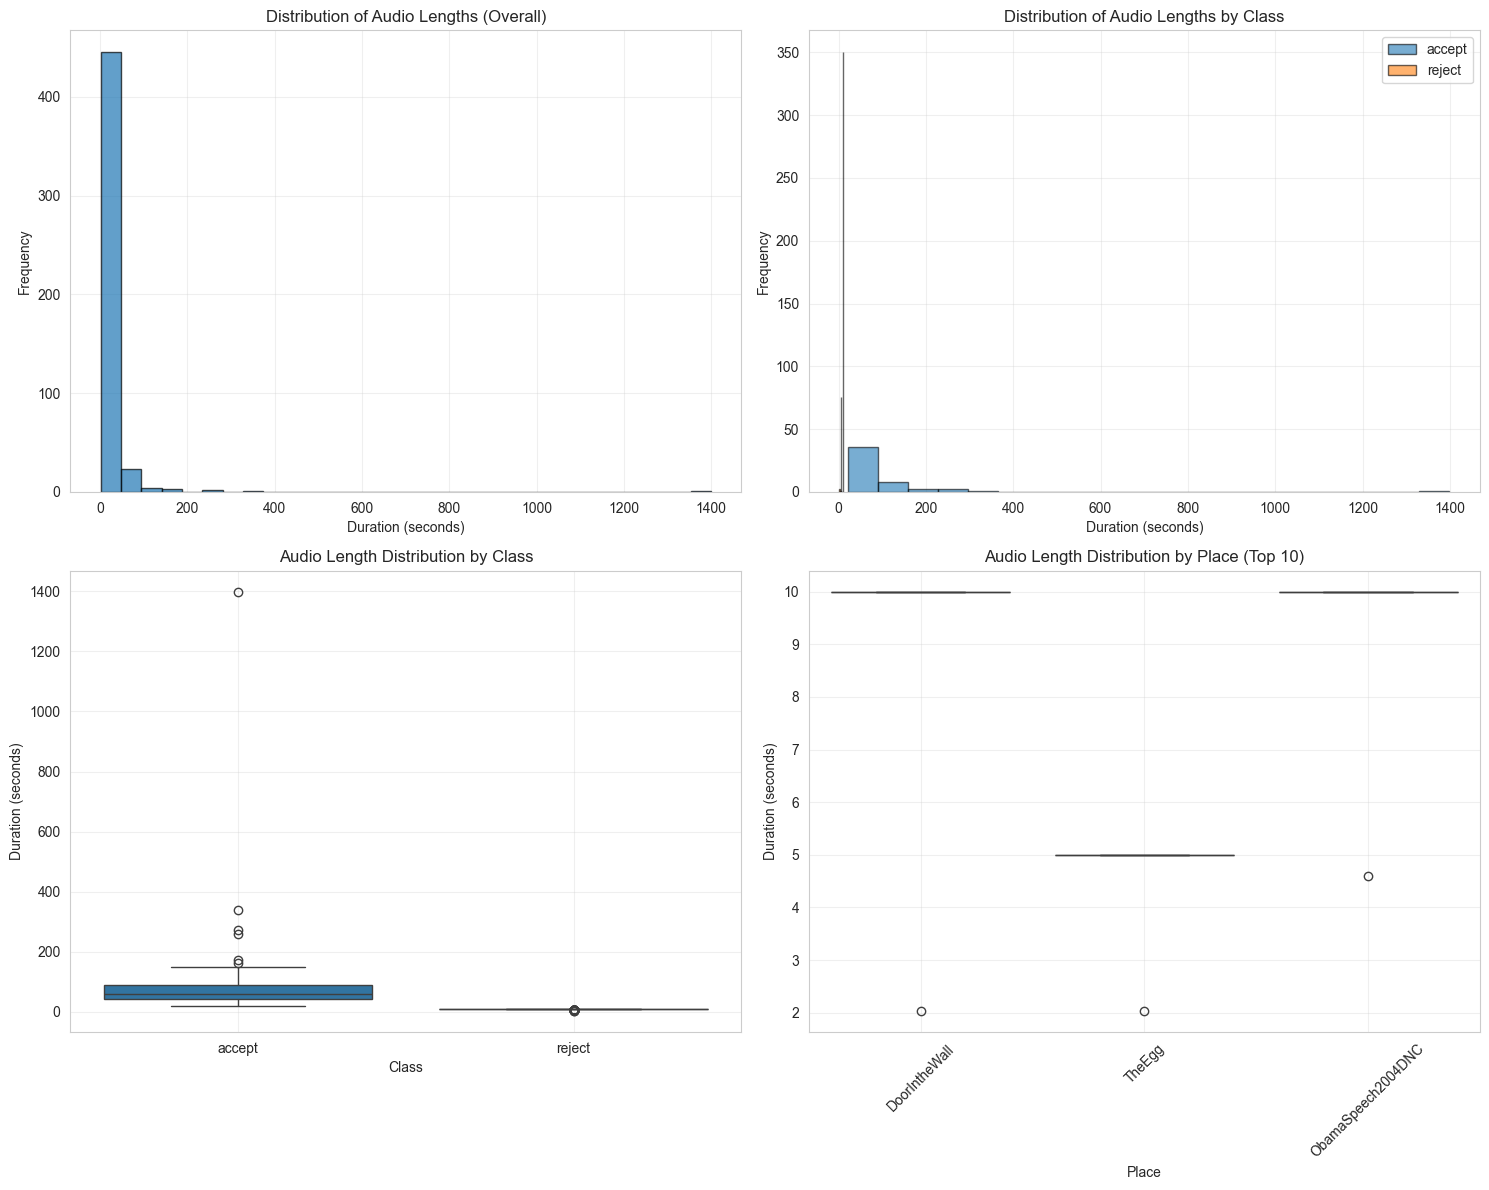

In [18]:
# Visualize audio length distributions
if not full_audio_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Overall histogram
    axes[0, 0].hist(full_audio_df['duration'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution of Audio Lengths (Overall)')
    axes[0, 0].set_xlabel('Duration (seconds)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histogram by class
    if len(full_audio_df['label'].unique()) > 1:
        for label in full_audio_df['label'].unique():
            label_data = full_audio_df[full_audio_df['label'] == label]['duration']
            axes[0, 1].hist(label_data, bins=20, alpha=0.6, label=label, edgecolor='black')
        axes[0, 1].set_title('Distribution of Audio Lengths by Class')
        axes[0, 1].set_xlabel('Duration (seconds)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Box plot by class
    if len(full_audio_df['label'].unique()) > 1:
        sns.boxplot(data=full_audio_df, x='label', y='duration', ax=axes[1, 0])
        axes[1, 0].set_title('Audio Length Distribution by Class')
        axes[1, 0].set_xlabel('Class')
        axes[1, 0].set_ylabel('Duration (seconds)')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Box plot by place if available
    if 'place' in full_audio_df.columns:
        place_data = full_audio_df[full_audio_df['place'].notna() & (full_audio_df['place'] != 'unknown')]
        if len(place_data) > 0 and len(place_data['place'].unique()) > 1:
            # Limit to top 10 places for readability
            top_places = place_data['place'].value_counts().head(10).index
            plot_df = place_data[place_data['place'].isin(top_places)]
            sns.boxplot(data=plot_df, x='place', y='duration', ax=axes[1, 1])
            axes[1, 1].set_title('Audio Length Distribution by Place (Top 10)')
            axes[1, 1].set_xlabel('Place')
            axes[1, 1].set_ylabel('Duration (seconds)')
            axes[1, 1].tick_params(axis='x', rotation=45)
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'No place data available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Audio Length by Place')
    else:
        axes[1, 1].text(0.5, 0.5, 'No place data available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Audio Length by Place')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize")


In [19]:
# Identify extremely short or extremely noisy recordings
if not full_audio_df.empty and len(full_audio_df) > 0:
    print("="*60)
    print("OUTLIER DETECTION")
    print("="*60)
    
    # Extremely short recordings (below 1st percentile or less than 1 second)
    duration_threshold_short = max(full_audio_df['duration'].quantile(0.01), 1.0)
    short_recordings = full_audio_df[full_audio_df['duration'] < duration_threshold_short]
    
    print(f"\n1. Extremely short recordings (< {duration_threshold_short:.2f} seconds):")
    print(f"   Found {len(short_recordings)} recordings")
    if len(short_recordings) > 0:
        print(short_recordings[['file_name', 'label', 'duration']].to_string(index=False))
    
    # Extremely long recordings (above 99th percentile)
    duration_threshold_long = full_audio_df['duration'].quantile(0.99)
    long_recordings = full_audio_df[full_audio_df['duration'] > duration_threshold_long]
    
    print(f"\n2. Extremely long recordings (> {duration_threshold_long:.2f} seconds):")
    print(f"   Found {len(long_recordings)} recordings")
    if len(long_recordings) > 0:
        print(long_recordings[['file_name', 'label', 'duration']].to_string(index=False))
    
    # Detect noisy recordings using ZCR and spectral analysis
    print("\n3. Analyzing noise levels...")
    noisy_recordings = []
    
    for idx, item in enumerate(full_audio_data):
        y = item['audio']
        sr = item['sr']
        
        # Zero Crossing Rate (high ZCR can indicate noise)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y)[0])
        
        # Spectral centroid (noisy signals often have different spectral characteristics)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        
        # RMS energy
        rms = np.mean(librosa.feature.rms(y=y)[0])
        
        # Store metrics
        item['zcr'] = zcr
        item['spectral_centroid'] = spectral_centroid
        item['rms'] = rms
    
    # Calculate thresholds for noise detection
    zcr_values = [item['zcr'] for item in full_audio_data]
    zcr_threshold_high = np.percentile(zcr_values, 95)
    
    rms_values = [item['rms'] for item in full_audio_data]
    rms_threshold_low = np.percentile(rms_values, 5)
    
    # Identify potentially noisy recordings
    for item in full_audio_data:
        if item['zcr'] > zcr_threshold_high or item['rms'] < rms_threshold_low:
            noisy_recordings.append({
                'file_name': item['file_name'],
                'label': item['label'],
                'zcr': item['zcr'],
                'rms': item['rms'],
                'spectral_centroid': item['spectral_centroid']
            })
    
    print(f"   Found {len(noisy_recordings)} potentially noisy recordings")
    if len(noisy_recordings) > 0:
        noisy_df = pd.DataFrame(noisy_recordings)
        print(noisy_df.to_string(index=False))
else:
    print("No data for outlier detection")


OUTLIER DETECTION

1. Extremely short recordings (< 5.00 seconds):
   Found 3 recordings
                  file_name  label  duration
            TheEgg_0076.wav reject  2.040812
ObamaSpeech2004DNC_0096.wav reject  4.597563
     DoorIntheWall_0254.wav reject  2.027750

2. Extremely long recordings (> 163.64 seconds):
   Found 5 recordings
                        file_name  label    duration
                       egecan.mp3 accept 1399.060000
    audio_2025-11-16_09-46-26.mp3 accept  338.048000
    audio_2025-11-16_09-47-01.mp3 accept  257.834687
    audio_2025-11-16_09-46-48.mp3 accept  172.245375
computer_speakers_Poddierohin.mp3 accept  272.960000

3. Analyzing noise levels...
   Found 44 potentially noisy recordings
                        file_name  label      zcr      rms  spectral_centroid
                     IMG_4849.mp3 accept 0.193688 0.083154        2217.893675
     Samuel L. Jackson laptop.m4a accept 0.181564 0.009202        2227.849035
    audio_2025-11-16_09-46-55.mp3 ac

## 2. Feature Extraction and Analysis


In [20]:
# Feature extraction function adapted from example
def extract_features(y, label=None, place=None, sr=16000, n_mfcc=13):
    """
    Extract comprehensive audio features from audio signal.
    """
    features = {}
    
    # Metadata
    if label is not None:
        features["label"] = label
    if place is not None:
        features["place"] = place
    
    ## Basic features
    features["y_mean"] = np.nanmean(y)
    features["y_std"] = np.nanstd(y)
    features["y_iqr"] = np.subtract(*np.percentile(y, [75, 25]))
    features["y_skew"] = sp.stats.skew(y)
    features["y_kurt"] = sp.stats.kurtosis(y)
    
    ## Temporal features
    # Root Mean Square energy
    features["rms"] = np.mean(librosa.feature.rms(y=y))
    
    # Zero Crossing Rate
    features["zcr"] = np.mean(librosa.feature.zero_crossing_rate(y))
    
    ## Spectral features
    # Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
        features[f"mfcc_{i+1}"] = np.mean(mfcc[i])
    
    # Spectral centroid
    features["spectral_centroid"] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    
    # Spectral bandwidth
    features["spectral_bandwidth"] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    
    # Rolloff
    features["rolloff"] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    # Spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    for i in range(spectral_contrast.shape[0]):
        features[f"spectral_contrast_{i+1}"] = np.mean(spectral_contrast[i])
    
    ## Harmonic features
    # F0 / Pitch
    try:
        f0, _, _ = librosa.pyin(y, fmin=50, fmax=300)
        features["f0_mean"] = np.nanmean(f0)
        features["f0_std"] = np.nanstd(f0)
    except:
        features["f0_mean"] = np.nan
        features["f0_std"] = np.nan
    
    # Harmonic-to-Noise-Ratio (HNR)
    if HAS_PARSELMOUTH:
        try:
            snd = parselmouth.Sound(y, sampling_frequency=sr)
            harmonicity = snd.to_harmonicity()
            hnr = harmonicity.values
            features["hnr"] = np.nanmean(hnr)
        except:
            features["hnr"] = np.nan
    else:
        features["hnr"] = np.nan
    
    return features

def process_audio(item):
    """Process audio item and extract features."""
    y = item['audio']
    sr = item['sr']
    label = item.get('label', None)
    
    # Get metadata
    metadata = item.get('metadata', {})
    place = metadata.get('place', None) if metadata else None
    
    print(f"Extracting features for: {item['file_name']}")
    return extract_features(y=y, sr=sr, label=label, place=place)


In [21]:
# Extract features from full audio files
if full_audio_data:
    print("Extracting features from full audio files...")
    features_list = []
    
    for item in full_audio_data:
        try:
            features = process_audio(item)
            features_list.append(features)
        except Exception as e:
            print(f"Error processing {item['file_name']}: {e}")
    
    features_df = pd.DataFrame(features_list)
    print(f"\n{'='*50}")
    print(f"Feature extraction complete!")
    print(f"Features DataFrame shape: {features_df.shape}")
    print(f"{'='*50}")
    print(f"\nColumns: {features_df.columns.tolist()}")
else:
    print("No audio data available for feature extraction")
    features_df = pd.DataFrame()


Extracting features from full audio files...
Extracting features for: laptop1_Nischa.mp3
Extracting features for: egecan.mp3
Extracting features for: IMG_4858.mp3
Extracting features for: audio_2025-11-16_09-46-36.mp3
Extracting features for: IMG_4849.mp3
Extracting features for: audio_2025-11-16_09-46-32.mp3
Extracting features for: audio_2025-11-16_09-46-26.mp3
Extracting features for: IMG_4848.mp3
Extracting features for: laptop1_Marques_Brownlee.mp3
Extracting features for: Matt_Davella_1.mp3
Extracting features for: Samuel L. Jackson laptop.m4a
Extracting features for: Matt_Davella_2.mp3
Extracting features for: audio_2025-11-16_09-46-40.mp3
Extracting features for: Natalie Portman.m4a
Extracting features for: audio_2025-11-16_09-46-55.mp3
Extracting features for: Matt_Davella_3.mp3
Extracting features for: audio_2025-11-16_09-47-01.mp3
Extracting features for: Samuel L Jackson laptop (3).m4a
Extracting features for: Samuel L Jackson laptop (2).m4a
Extracting features for: audio_2

In [22]:
# Display feature statistics
if not features_df.empty:
    print("Feature Statistics:")
    print(features_df.describe())
    print(f"\nFirst few rows:")
    print(features_df.head())


Feature Statistics:
           y_mean       y_std       y_iqr      y_skew      y_kurt         rms  \
count  479.000000  479.000000  479.000000  478.000000  478.000000  479.000000   
mean    -0.000217    0.091300    0.045419    0.518569    6.507978    0.073237   
std      0.000232    0.037928    0.033471    0.629989    4.743995    0.032597   
min     -0.000823    0.000000    0.000000   -0.800272    0.135119    0.000000   
25%     -0.000397    0.050115    0.016897   -0.087959    4.302907    0.040366   
50%     -0.000203    0.104053    0.043079    0.847835    5.512224    0.083524   
75%     -0.000021    0.118751    0.062640    1.050218    7.392036    0.096456   
max      0.000826    0.165605    0.225542    1.872884   57.942096    0.160754   

              zcr       mfcc_1      mfcc_2      mfcc_3  ...  \
count  479.000000   479.000000  479.000000  479.000000  ...   
mean     0.130846  -277.911499   84.533630    4.275321  ...   
std      0.030044    76.149773   19.321159   22.595442  ...  

### Basic Feature Visualizations


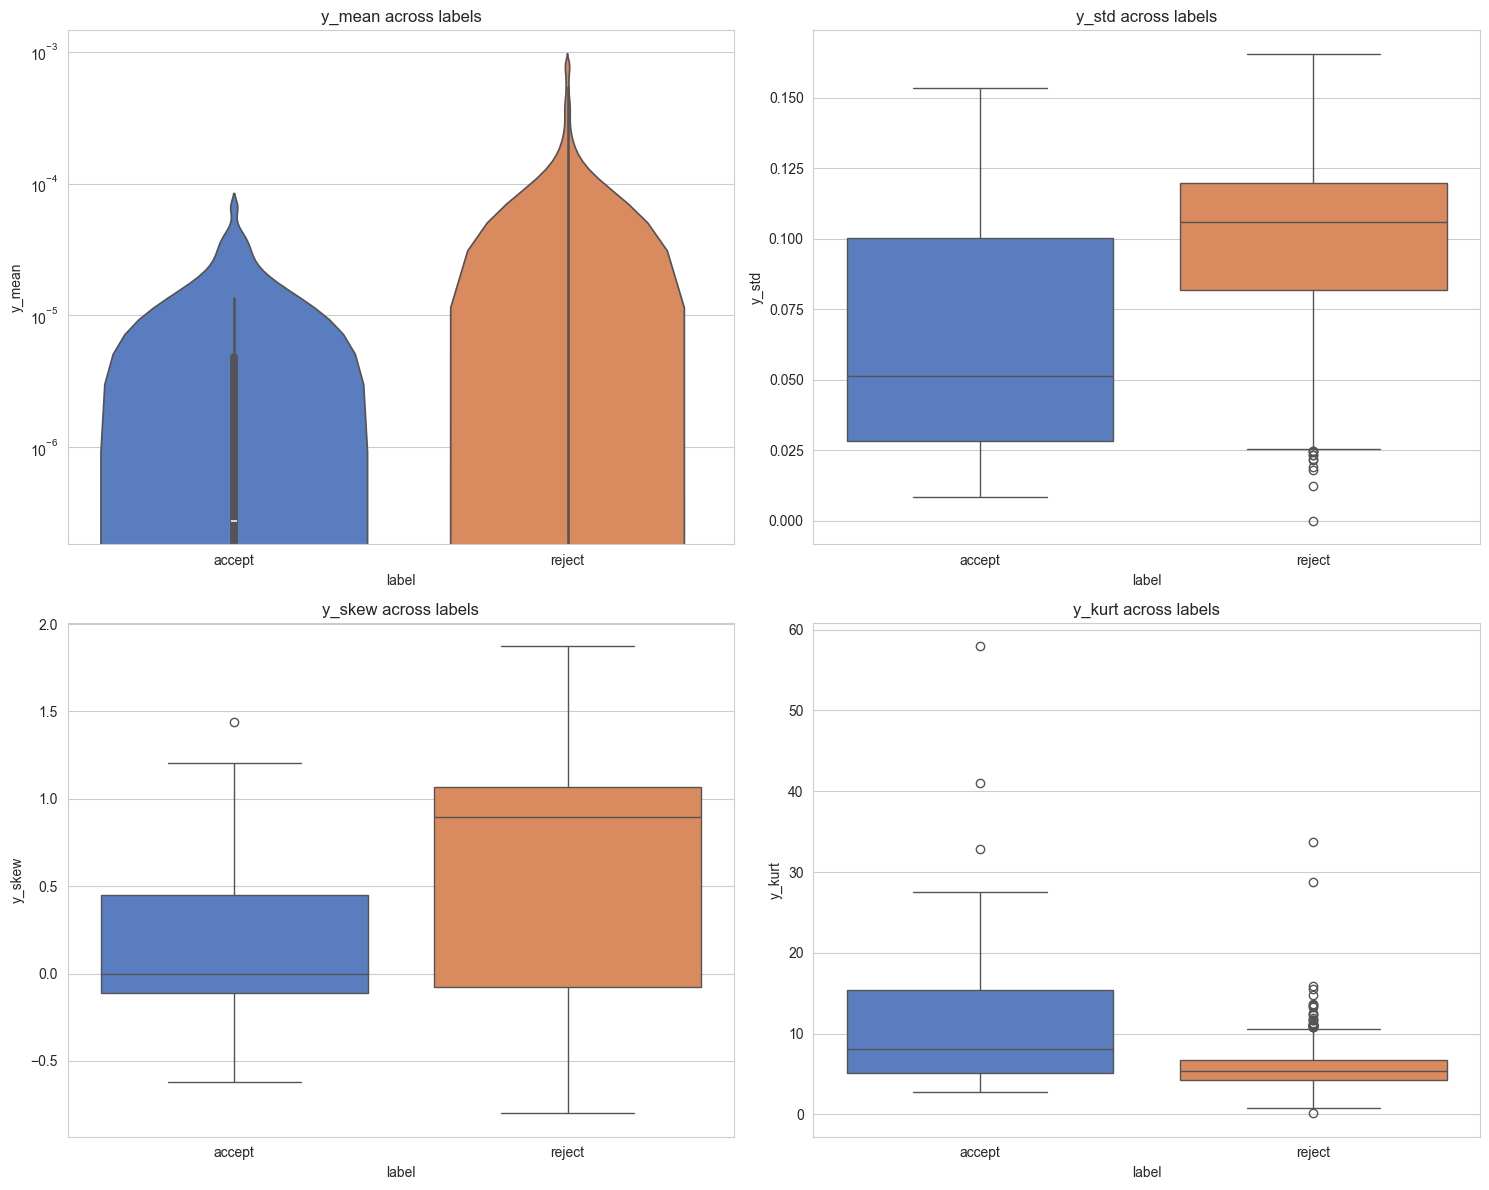

In [23]:
# Basic feature visualizations by label
if not features_df.empty and 'label' in features_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # y_mean by label
    if len(features_df['label'].unique()) > 1:
        sns.violinplot(y="y_mean", data=features_df, x="label", palette="muted", ax=axes[0, 0])
        axes[0, 0].set_title("y_mean across labels")
        axes[0, 0].set_yscale('log')
    
    # y_std by label
    if len(features_df['label'].unique()) > 1:
        sns.boxplot(y="y_std", data=features_df, x="label", palette="muted", ax=axes[0, 1])
        axes[0, 1].set_title("y_std across labels")
    
    # y_skew by label
    if len(features_df['label'].unique()) > 1:
        sns.boxplot(y="y_skew", data=features_df, x="label", palette="muted", ax=axes[1, 0])
        axes[1, 0].set_title("y_skew across labels")
    
    # y_kurt by label
    if len(features_df['label'].unique()) > 1:
        sns.boxplot(y="y_kurt", data=features_df, x="label", palette="muted", ax=axes[1, 1])
        axes[1, 1].set_title("y_kurt across labels")
    
    plt.tight_layout()
    plt.show()
else:
    print("No features or label data available for visualization")


### Clustering Analysis


Clustering complete: 2 clusters


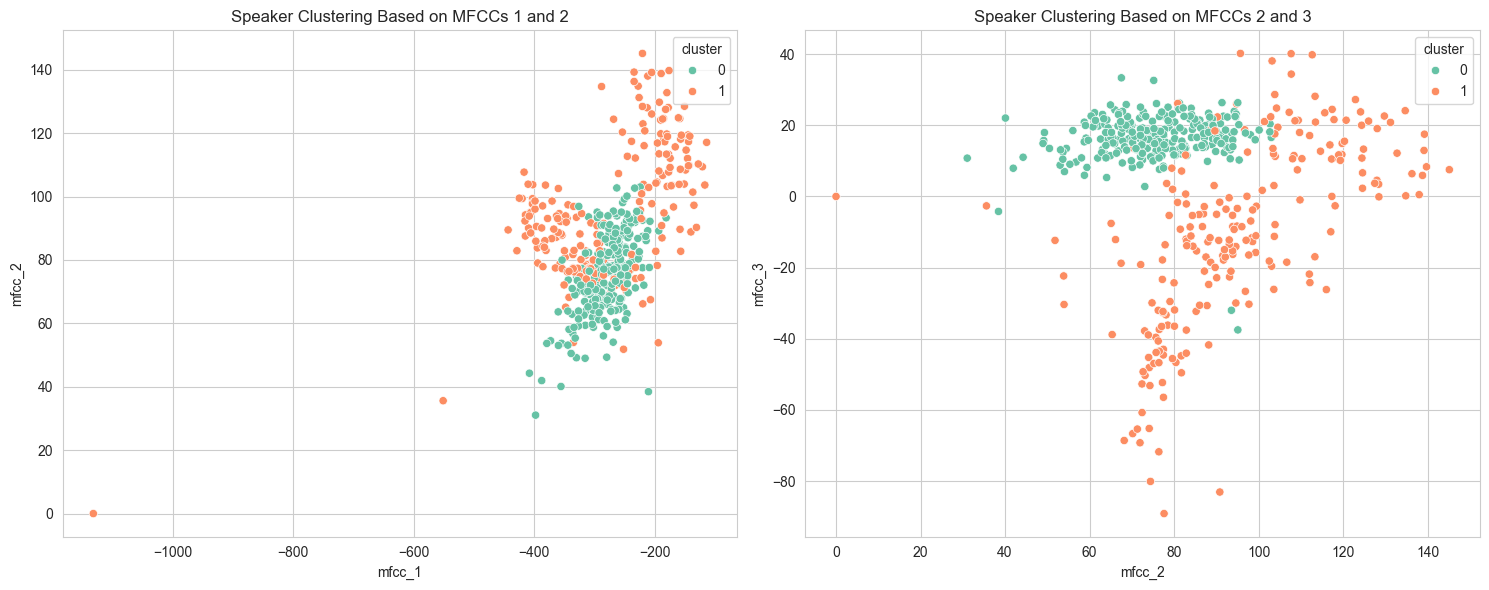


Cluster vs Label comparison:
label    accept  reject
cluster                
0             7     254
1            43     175


In [25]:
# K-Means clustering on MFCC features
if not features_df.empty:
    # Select MFCC features
    n_mfcc = 13
    mfcc_cols = [f"mfcc_{i+1}" for i in range(n_mfcc)]
    available_mfcc_cols = [col for col in mfcc_cols if col in features_df.columns]
    
    if len(available_mfcc_cols) > 0:
        mfcc_features = features_df[available_mfcc_cols].dropna()
        
        if len(mfcc_features) > 1:
            # Standardize features
            scaler = StandardScaler()
            mfcc_scaled = scaler.fit_transform(mfcc_features)
            
            # Determine number of clusters (use number of labels if available, else 2)
            n_clusters = 2
            if 'label' in features_df.columns:
                n_clusters = min(len(features_df['label'].unique()), len(mfcc_features))
            
            # K-Means clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=19, n_init=10)
            cluster_labels = kmeans.fit_predict(mfcc_scaled)
            
            # Add cluster labels to dataframe
            features_df_clustered = features_df.loc[mfcc_features.index].copy()
            features_df_clustered["cluster"] = cluster_labels
            
            print(f"Clustering complete: {n_clusters} clusters")
            
            # Visualize clusters
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # Cluster by MFCC 1 and 2
            if 'mfcc_1' in features_df_clustered.columns and 'mfcc_2' in features_df_clustered.columns:
                sns.scatterplot(
                    x=features_df_clustered["mfcc_1"], 
                    y=features_df_clustered["mfcc_2"], 
                    hue=features_df_clustered["cluster"], 
                    palette="Set2",
                    ax=axes[0]
                )
                axes[0].set_title("Speaker Clustering Based on MFCCs 1 and 2")
            
            # Cluster by MFCC 2 and 3
            if 'mfcc_2' in features_df_clustered.columns and 'mfcc_3' in features_df_clustered.columns:
                sns.scatterplot(
                    x=features_df_clustered["mfcc_2"], 
                    y=features_df_clustered["mfcc_3"], 
                    hue=features_df_clustered["cluster"], 
                    palette="Set2",
                    ax=axes[1]
                )
                axes[1].set_title("Speaker Clustering Based on MFCCs 2 and 3")
            
            plt.tight_layout()
            plt.show()
            
            # Compare clusters with actual labels if available
            if 'label' in features_df_clustered.columns:
                print("\nCluster vs Label comparison:")
                print(pd.crosstab(features_df_clustered['cluster'], features_df_clustered['label']))
        else:
            print("Not enough valid MFCC data for clustering")
    else:
        print("MFCC features not available for clustering")
else:
    print("No features available for clustering")


### Spectral Analysis


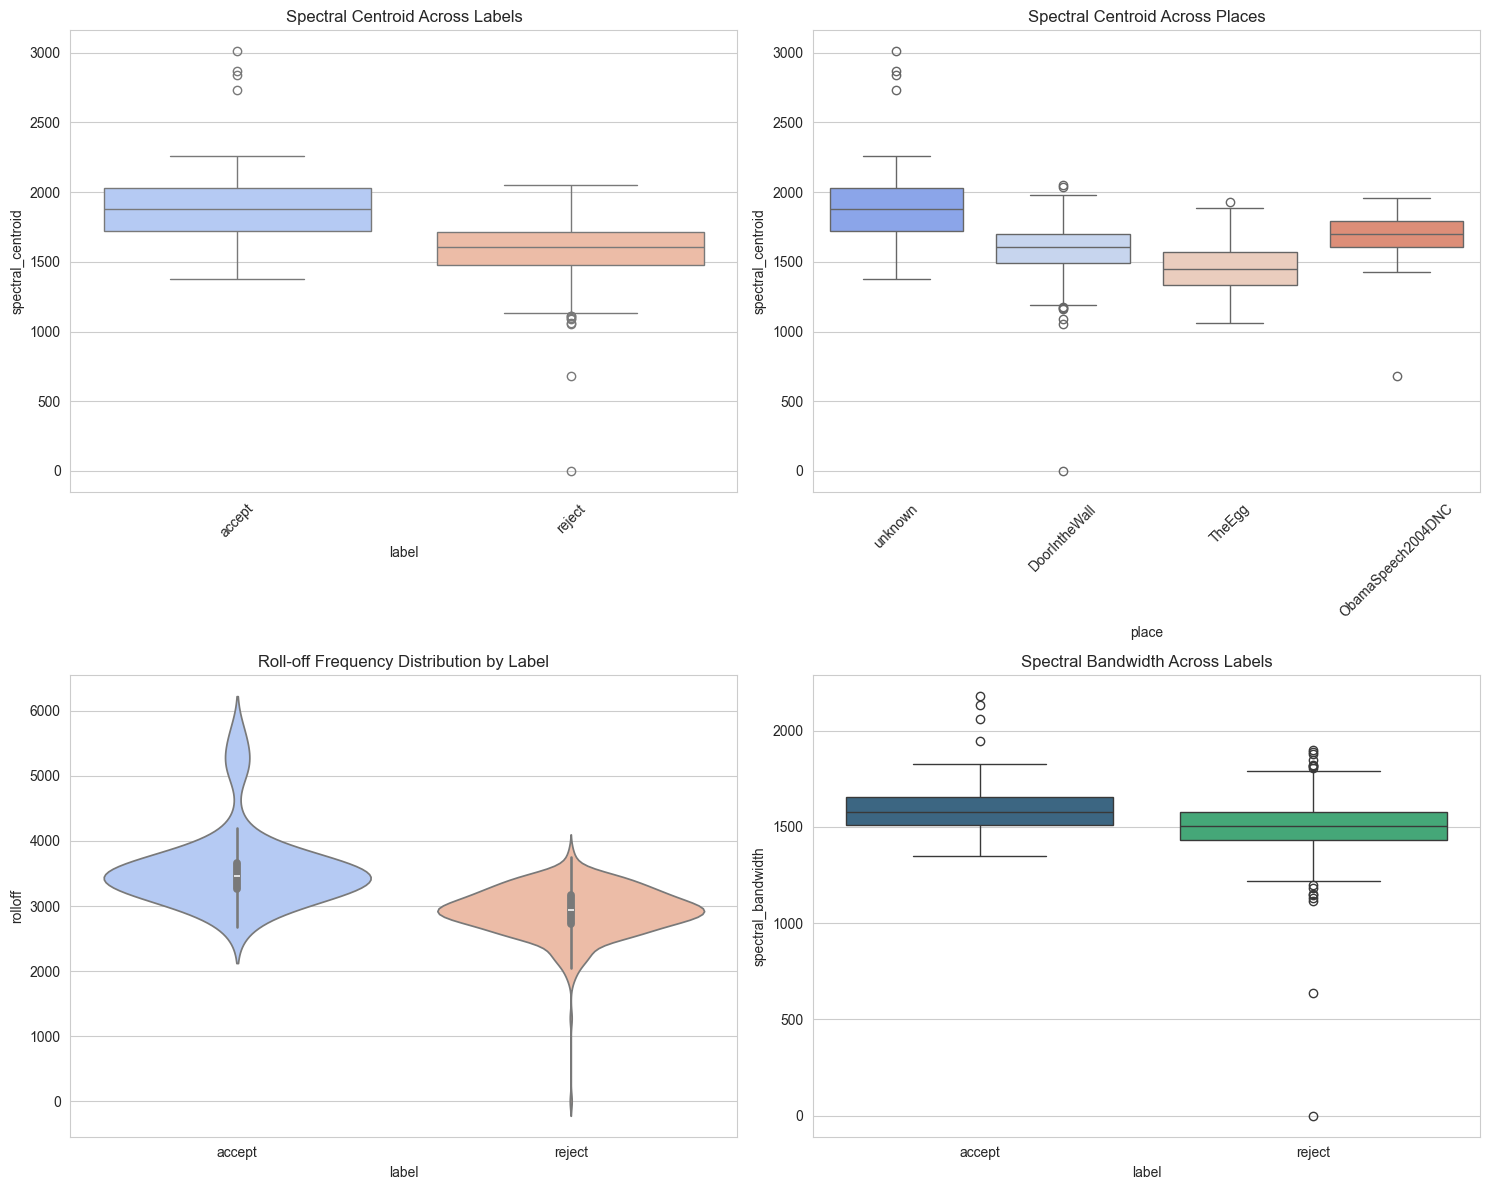

In [26]:
# Spectral feature analysis
if not features_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Spectral centroid by label
    if 'label' in features_df.columns and 'spectral_centroid' in features_df.columns:
        if len(features_df['label'].unique()) > 1:
            sns.boxplot(x="label", y="spectral_centroid", data=features_df, palette="coolwarm", ax=axes[0, 0])
            axes[0, 0].set_title("Spectral Centroid Across Labels")
            axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Spectral centroid by place
    if 'place' in features_df.columns and 'spectral_centroid' in features_df.columns:
        place_data = features_df[features_df['place'].notna()]
        if len(place_data) > 0 and len(place_data['place'].unique()) > 1:
            sns.boxplot(x="place", y="spectral_centroid", data=place_data, palette="coolwarm", ax=axes[0, 1])
            axes[0, 1].set_title("Spectral Centroid Across Places")
            axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Rolloff by label
    if 'label' in features_df.columns and 'rolloff' in features_df.columns:
        if len(features_df['label'].unique()) > 1:
            sns.violinplot(x="label", y="rolloff", data=features_df, palette="coolwarm", ax=axes[1, 0])
            axes[1, 0].set_title("Roll-off Frequency Distribution by Label")
    
    # Spectral bandwidth by label
    if 'label' in features_df.columns and 'spectral_bandwidth' in features_df.columns:
        if len(features_df['label'].unique()) > 1:
            sns.boxplot(x="label", y="spectral_bandwidth", data=features_df, palette="viridis", ax=axes[1, 1])
            axes[1, 1].set_title("Spectral Bandwidth Across Labels")
    
    plt.tight_layout()
    plt.show()
else:
    print("No features available for spectral analysis")


### Pitch (F0) Analysis


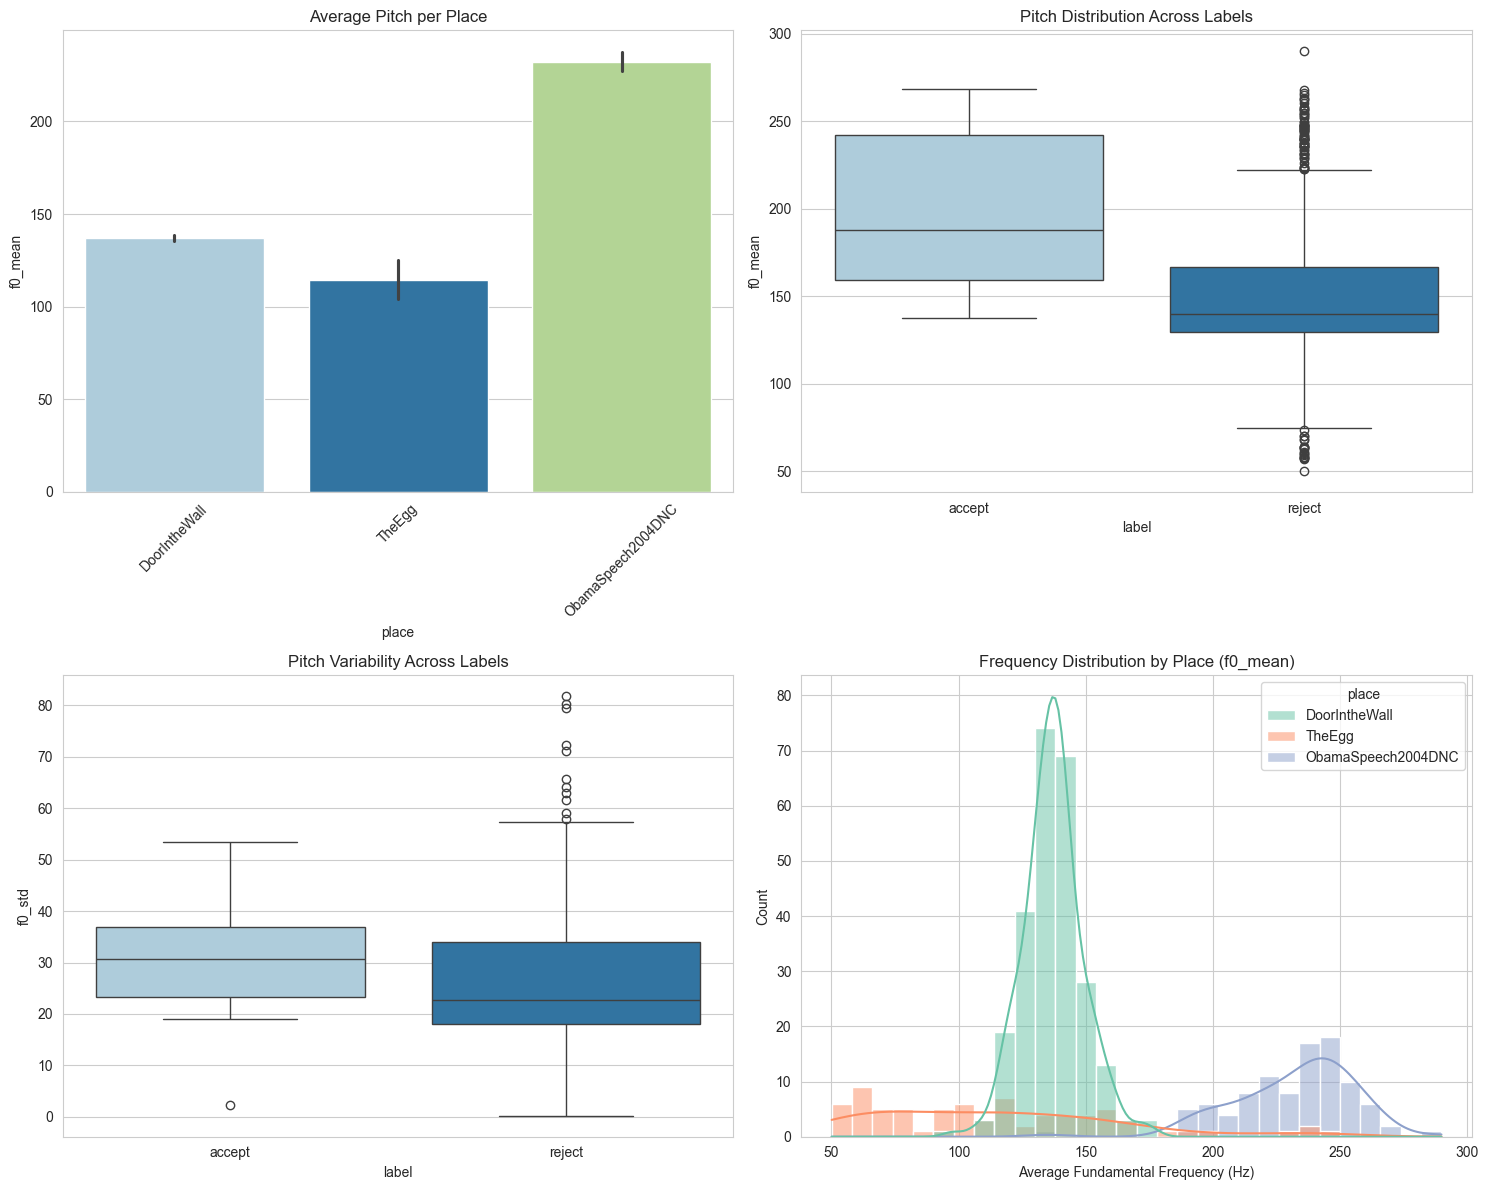

In [27]:
# Pitch analysis
if not features_df.empty and 'f0_mean' in features_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # F0 mean by place
    if 'place' in features_df.columns:
        place_data = features_df[features_df['place'].notna() & (features_df['place'] != 'unknown') & features_df['f0_mean'].notna()]
        if len(place_data) > 0 and len(place_data['place'].unique()) > 1:
            sns.barplot(x="place", y="f0_mean", data=place_data, palette="Paired", ax=axes[0, 0])
            axes[0, 0].set_title("Average Pitch per Place")
            axes[0, 0].tick_params(axis='x', rotation=45)
    
    # F0 mean by label
    if 'label' in features_df.columns:
        label_data = features_df[features_df['f0_mean'].notna()]
        if len(label_data) > 0 and len(label_data['label'].unique()) > 1:
            sns.boxplot(x="label", y="f0_mean", data=label_data, palette="Paired", ax=axes[0, 1])
            axes[0, 1].set_title("Pitch Distribution Across Labels")
    
    # F0 std by label (pitch variability)
    if 'label' in features_df.columns and 'f0_std' in features_df.columns:
        label_data = features_df[features_df['f0_std'].notna()]
        if len(label_data) > 0 and len(label_data['label'].unique()) > 1:
            sns.boxplot(x="label", y="f0_std", data=label_data, palette="Paired", ax=axes[1, 0])
            axes[1, 0].set_title("Pitch Variability Across Labels")
    
    # Frequency distribution by place
    if 'place' in features_df.columns:
        place_data = features_df[features_df['place'].notna() & (features_df['place'] != 'unknown') & features_df['f0_mean'].notna()]
        if len(place_data) > 0 and len(place_data['place'].unique()) > 1:
            sns.histplot(data=place_data, x='f0_mean', hue='place', kde=True, palette='Set2', bins=30, ax=axes[1, 1])
            axes[1, 1].set_title("Frequency Distribution by Place (f0_mean)")
            axes[1, 1].set_xlabel("Average Fundamental Frequency (Hz)")
            axes[1, 1].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()
else:
    print("No pitch (F0) data available for analysis")


### Additional Analyses: Frequency Spectrum, Silence, Waveforms


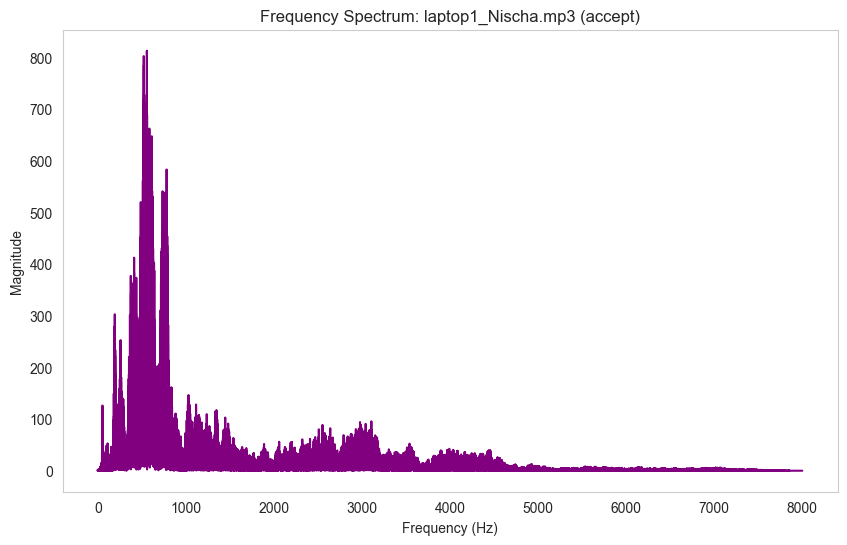

In [28]:
# Frequency spectrum visualization
def plot_frequency_spectrum(y, sr, title):
    """Plot the frequency spectrum of an audio signal using Fourier Transform."""
    fft = np.fft.fft(y)
    magnitude = np.abs(fft)
    freq = np.fft.fftfreq(len(magnitude), 1 / sr)
    half_spectrum = freq[:len(freq) // 2], magnitude[:len(magnitude) // 2]
    
    plt.figure(figsize=(10, 6))
    plt.plot(half_spectrum[0], half_spectrum[1], color='purple')
    plt.title(f"Frequency Spectrum: {title}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

# Plot frequency spectrum for a sample
if full_audio_data:
    sample_item = full_audio_data[0]
    plot_frequency_spectrum(
        sample_item['audio'], 
        sample_item['sr'], 
        title=f"{sample_item['file_name']} ({sample_item['label']})"
    )
else:
    print("No audio data available for frequency spectrum analysis")


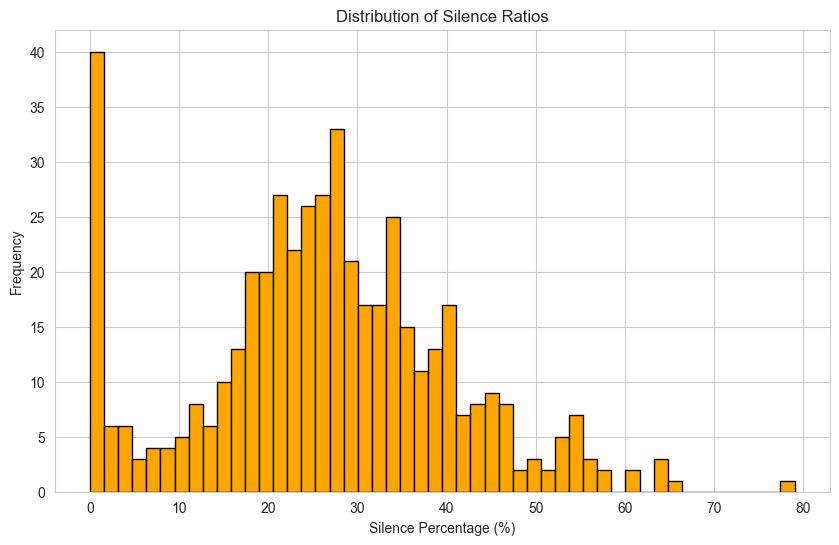

Silence Ratios (Min, Max, Mean): 0.00%, 79.04%, 26.36%


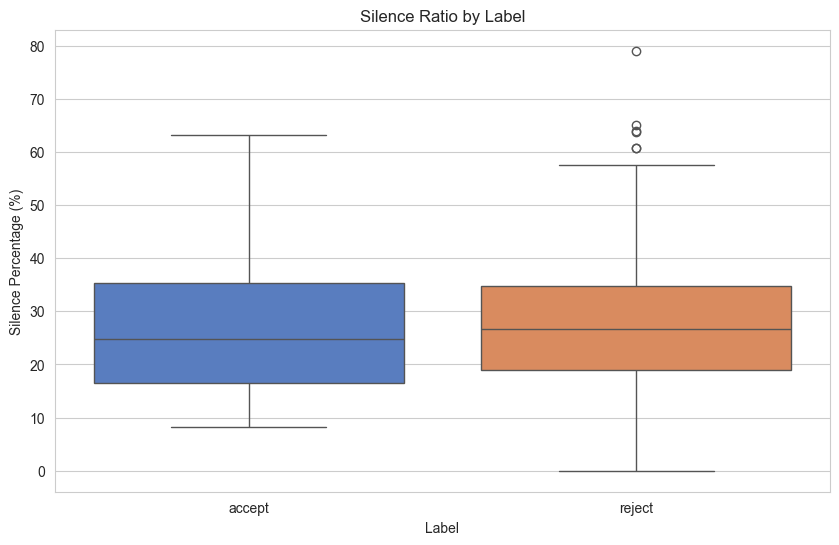

In [29]:
# Silence analysis
def analyze_silence(audio_data, sr=16000, top_db=20):
    """Analyze and visualize the silence ratio (percentage) for all audio files."""
    silence_ratios = []
    
    for item in audio_data:
        y = item['audio']
        file_name = item['file_name']
        label = item.get('label', 'unknown')
        
        try:
            # Split audio into non-silent intervals
            non_silent_intervals = librosa.effects.split(y, top_db=top_db)
            non_silent_duration = sum((end - start) for start, end in non_silent_intervals)
            total_duration = len(y)
            silence_ratio = 1 - (non_silent_duration / total_duration)
            silence_ratios.append({
                'file_name': file_name,
                'label': label,
                'silence_ratio': silence_ratio * 100
            })
        except Exception as e:
            print(f"Error analyzing silence for {file_name}: {e}")
    
    if silence_ratios:
        silence_df = pd.DataFrame(silence_ratios)
        
        # Plot the silence ratio distribution
        plt.figure(figsize=(10, 6))
        plt.hist(silence_df["silence_ratio"], bins=50, color='orange', edgecolor='black')
        plt.title("Distribution of Silence Ratios")
        plt.xlabel("Silence Percentage (%)")
        plt.ylabel("Frequency")
        plt.show()
        
        print(f"Silence Ratios (Min, Max, Mean): {silence_df['silence_ratio'].min():.2f}%, "
              f"{silence_df['silence_ratio'].max():.2f}%, {silence_df['silence_ratio'].mean():.2f}%")
        
        # Silence ratio by label
        if len(silence_df['label'].unique()) > 1:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=silence_df, x='label', y='silence_ratio', palette='muted')
            plt.title("Silence Ratio by Label")
            plt.xlabel("Label")
            plt.ylabel("Silence Percentage (%)")
            plt.show()
        
        return silence_df
    else:
        print("No silence data available")
        return pd.DataFrame()

if full_audio_data:
    silence_df = analyze_silence(full_audio_data)
else:
    print("No audio data available for silence analysis")


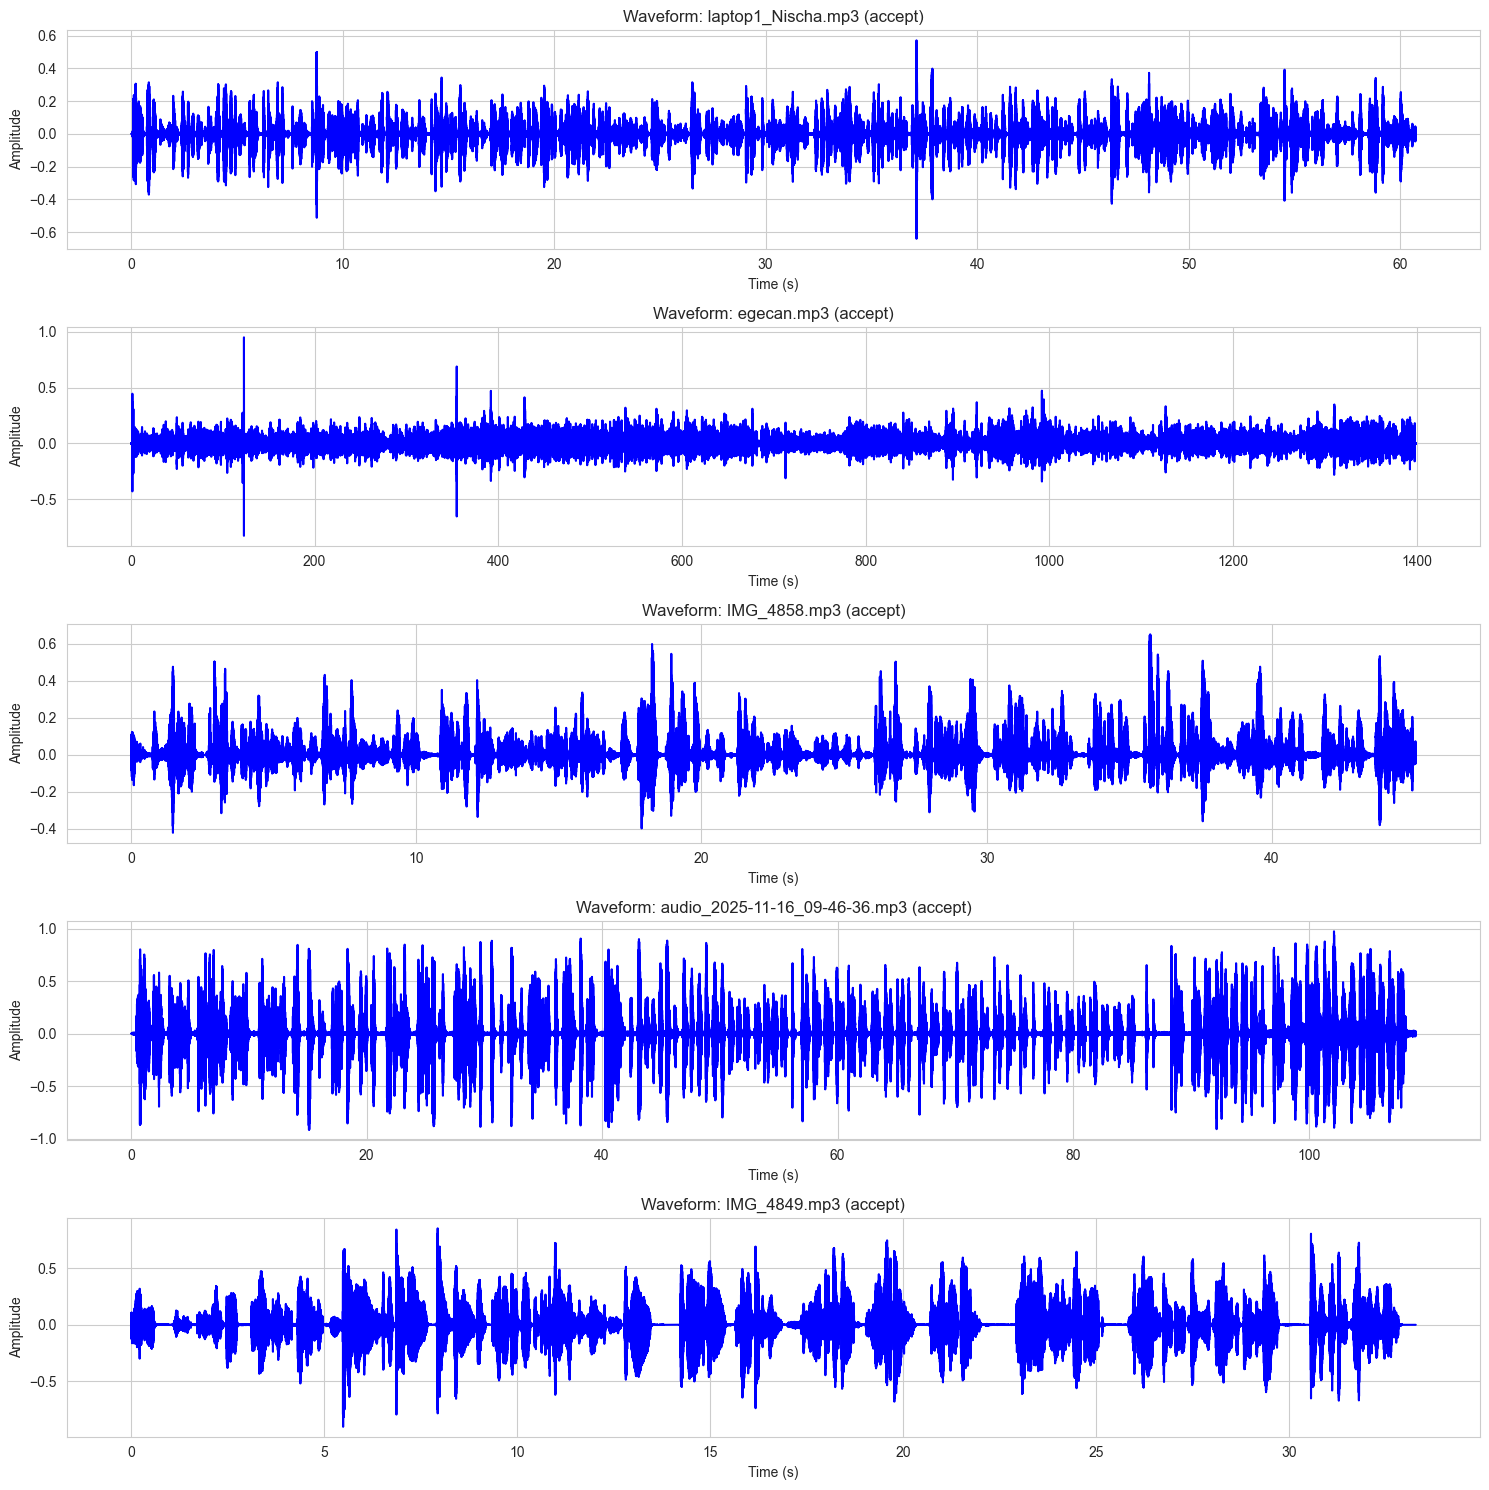

In [30]:
# Waveform visualization
def plot_waveforms(audio_data, num_samples=5):
    """Plot waveforms of selected audio samples."""
    plt.figure(figsize=(15, num_samples * 3))
    for i, item in enumerate(audio_data[:num_samples]):
        y = item['audio']
        sr = item['sr']
        label = item.get('label', 'unknown')
        file_name = item['file_name']
        
        plt.subplot(num_samples, 1, i + 1)
        time_axis = np.arange(len(y)) / sr
        plt.plot(time_axis, y, color='blue')
        plt.title(f"Waveform: {file_name} ({label})")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

if full_audio_data:
    plot_waveforms(full_audio_data, num_samples=min(5, len(full_audio_data)))
else:
    print("No audio data available for waveform visualization")


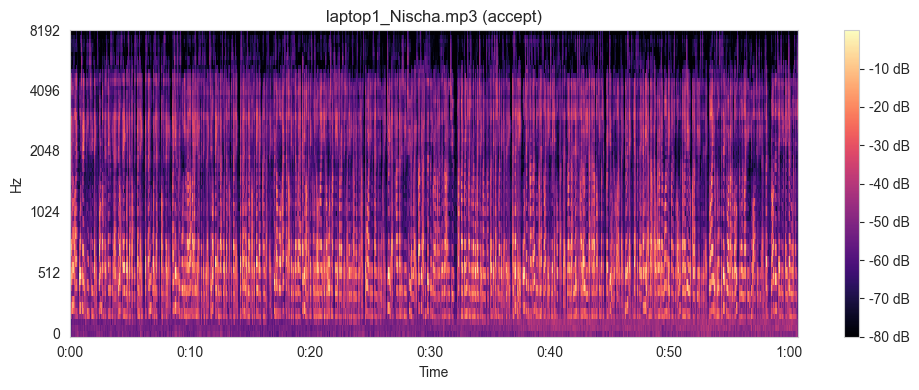

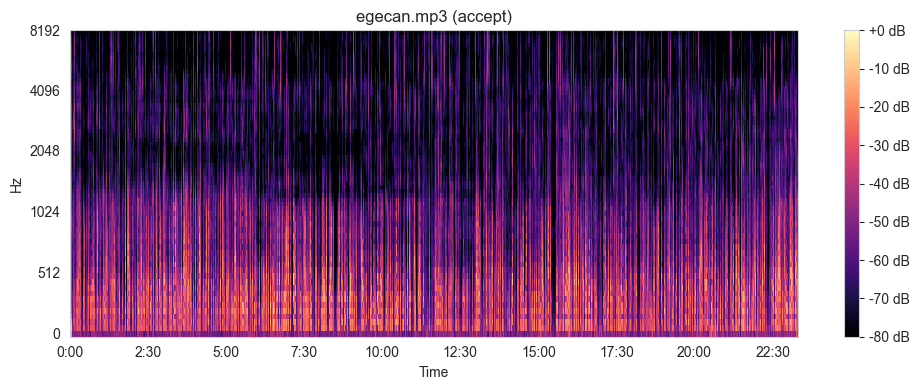

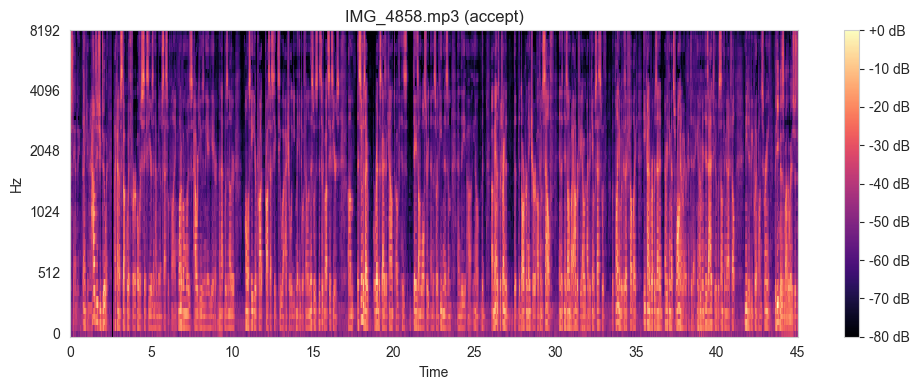

In [31]:
# Spectrogram examples
def plot_spectrogram(y, sr, title):
    """Plot mel spectrogram of an audio signal."""
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", fmax=8000)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot spectrograms for samples from different labels
if full_audio_data:
    # Get samples from different labels
    labels_seen = set()
    samples_to_plot = []
    for item in full_audio_data:
        label = item.get('label', 'unknown')
        if label not in labels_seen or len(samples_to_plot) < 3:
            samples_to_plot.append(item)
            labels_seen.add(label)
        if len(samples_to_plot) >= 3:
            break
    
    for item in samples_to_plot:
        plot_spectrogram(
            item['audio'], 
            item['sr'], 
            title=f"{item['file_name']} ({item.get('label', 'unknown')})"
        )
else:
    print("No audio data available for spectrogram visualization")


## 3. EDA on Segments and Spectrograms


In [32]:
# Load segmented audio files
def load_segmented_audio(audio_dir, sr=16000):
    """Load segmented audio files from subdirectories."""
    segment_data = []
    audio_extensions = {'.wav', '.mp3', '.flac', '.m4a', '.ogg'}
    
    if not audio_dir.exists():
        print(f"Audio directory not found: {audio_dir}")
        return segment_data
    
    # Look for subdirectories (each might be a different clip set)
    for subdir in audio_dir.iterdir():
        if subdir.is_dir() and subdir.name != '__pycache__':
            print(f"Loading segments from: {subdir.name}")
            for audio_file in subdir.rglob('*'):
                if audio_file.suffix.lower() in audio_extensions:
                    try:
                        y, sample_rate = librosa.load(str(audio_file), sr=sr)
                        file_name = audio_file.name
                        
                        # Try to extract label from filename (common patterns: accept_*, reject_*)
                        label = 'unknown'
                        if 'accept' in file_name.lower():
                            label = 'accept'
                        elif 'reject' in file_name.lower():
                            label = 'reject'
                        
                        # Try to extract speaker info from filename if possible
                        speaker = None
                        # Common pattern: speaker_filename or speaker_filename_*
                        parts = file_name.split('_')
                        if len(parts) > 1:
                            # Heuristic: if first part looks like a speaker ID
                            potential_speaker = parts[0]
                            if len(potential_speaker) <= 10 and potential_speaker.isalnum():
                                speaker = potential_speaker
                        
                        segment_data.append({
                            'file_path': str(audio_file),
                            'file_name': file_name,
                            'label': label,
                            'speaker': speaker,
                            'audio': y,
                            'sr': sample_rate,
                            'duration': len(y) / sample_rate,
                            'num_samples': len(y)
                        })
                    except Exception as e:
                        print(f"Failed to load {audio_file}: {e}")
    
    print(f"\n{'='*50}")
    print(f"Loaded {len(segment_data)} segment(s)")
    print(f"{'='*50}")
    return segment_data

# Load segments
segmented_audio_data = load_segmented_audio(AUDIO_DIR)


Loading segments from: segments_3s

Loaded 2192 segment(s)


In [33]:
# Analyze segments: compute amplitude statistics
if segmented_audio_data:
    print("Computing segment statistics...")
    segment_stats = []
    
    for item in segmented_audio_data:
        y = item['audio']
        stats = {
            'file_name': item['file_name'],
            'label': item['label'],
            'speaker': item.get('speaker', 'unknown'),
            'duration': item['duration'],
            'num_samples': item['num_samples'],
            'mean_amplitude': np.mean(np.abs(y)),
            'max_amplitude': np.max(np.abs(y)),
            'std_amplitude': np.std(y),
            'rms': np.sqrt(np.mean(y**2))
        }
        segment_stats.append(stats)
    
    segment_stats_df = pd.DataFrame(segment_stats)
    print(f"\nSegment Statistics DataFrame shape: {segment_stats_df.shape}")
    print(segment_stats_df.head())
    
    # Check segment length consistency
    print("\n" + "="*60)
    print("SEGMENT LENGTH CONSISTENCY CHECK")
    print("="*60)
    print(f"Number of unique durations: {segment_stats_df['duration'].nunique()}")
    print(f"Duration statistics:")
    print(segment_stats_df['duration'].describe())
    print(f"\nNumber of unique sample counts: {segment_stats_df['num_samples'].nunique()}")
    print(f"Sample count statistics:")
    print(segment_stats_df['num_samples'].describe())
    
    # Check if segments are consistent (within 1% variation)
    duration_std = segment_stats_df['duration'].std()
    duration_mean = segment_stats_df['duration'].mean()
    if duration_mean > 0:
        cv = (duration_std / duration_mean) * 100
        print(f"\nCoefficient of Variation: {cv:.2f}%")
        if cv < 1.0:
            print("✓ Segments have consistent length (CV < 1%)")
        else:
            print(f"⚠ Segments vary in length (CV = {cv:.2f}%)")
else:
    print("No segmented audio files found")
    segment_stats_df = pd.DataFrame()


Computing segment statistics...

Segment Statistics DataFrame shape: (2192, 9)
                            file_name   label speaker  duration  num_samples  \
0  reject_DoorIntheWall_0159_0001.wav  reject  reject       3.0        48000   
1  reject_DoorIntheWall_0158_0001.wav  reject  reject       3.0        48000   
2      accept_laptop1_Nischa_0000.wav  accept  accept       3.0        48000   
3              accept_egecan_0272.wav  accept  accept       3.0        48000   
4              accept_egecan_0266.wav  accept  accept       3.0        48000   

   mean_amplitude  max_amplitude  std_amplitude       rms  
0        0.125915       0.773041       0.176426  0.176427  
1        0.117353       0.721649       0.167503  0.167503  
2        0.028901       0.370392       0.052547  0.052547  
3        0.016912       0.164093       0.026930  0.026930  
4        0.015836       0.158554       0.024584  0.024584  

SEGMENT LENGTH CONSISTENCY CHECK
Number of unique durations: 1
Duration statist

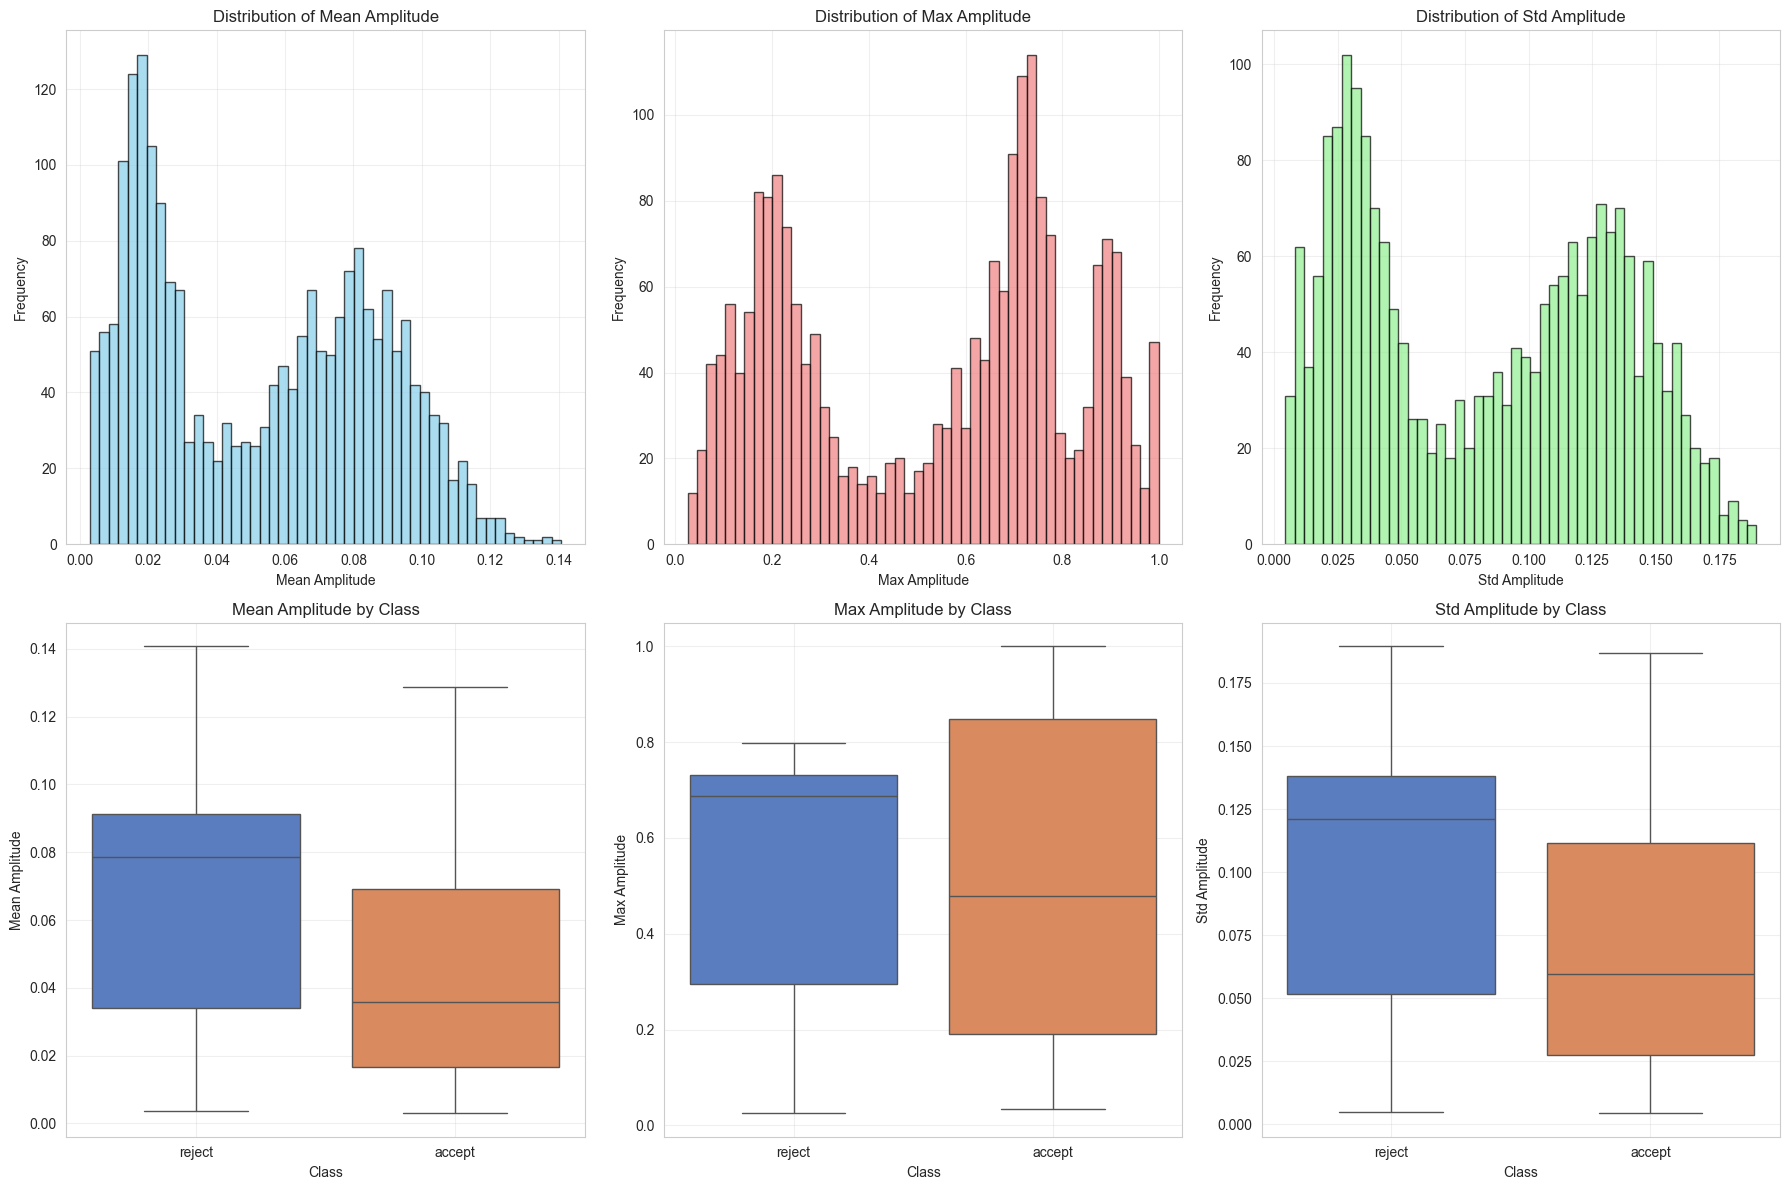

In [35]:
# Visualize segment statistics
if not segment_stats_df.empty:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Histogram of mean amplitude
    axes[0, 0].hist(segment_stats_df['mean_amplitude'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Mean Amplitude')
    axes[0, 0].set_xlabel('Mean Amplitude')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histogram of max amplitude
    axes[0, 1].hist(segment_stats_df['max_amplitude'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Distribution of Max Amplitude')
    axes[0, 1].set_xlabel('Max Amplitude')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Histogram of std amplitude
    axes[0, 2].hist(segment_stats_df['std_amplitude'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[0, 2].set_title('Distribution of Std Amplitude')
    axes[0, 2].set_xlabel('Std Amplitude')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Mean amplitude by class
    if len(segment_stats_df['label'].unique()) > 1:
        sns.boxplot(data=segment_stats_df, x='label', y='mean_amplitude', ax=axes[1, 0], palette='muted')
        axes[1, 0].set_title('Mean Amplitude by Class')
        axes[1, 0].set_xlabel('Class')
        axes[1, 0].set_ylabel('Mean Amplitude')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Max amplitude by class
    if len(segment_stats_df['label'].unique()) > 1:
        sns.boxplot(data=segment_stats_df, x='label', y='max_amplitude', ax=axes[1, 1], palette='muted')
        axes[1, 1].set_title('Max Amplitude by Class')
        axes[1, 1].set_xlabel('Class')
        axes[1, 1].set_ylabel('Max Amplitude')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Std amplitude by class
    if len(segment_stats_df['label'].unique()) > 1:
        sns.boxplot(data=segment_stats_df, x='label', y='std_amplitude', ax=axes[1, 2], palette='muted')
        axes[1, 2].set_title('Std Amplitude by Class')
        axes[1, 2].set_xlabel('Class')
        axes[1, 2].set_ylabel('Std Amplitude')
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No segment data to visualize")


In [36]:
# Load and analyze spectrograms
def load_spectrogram_images(spectrogram_dir):
    """Load spectrogram image files."""
    spectrogram_data = []
    
    if not spectrogram_dir.exists():
        print(f"Spectrogram directory not found: {spectrogram_dir}")
        return spectrogram_data
    
    # Look for subdirectories
    for subdir in spectrogram_dir.iterdir():
        if subdir.is_dir():
            print(f"Loading spectrograms from: {subdir.name}")
            for img_file in subdir.rglob('*.png'):
                try:
                    img = Image.open(img_file)
                    img_array = np.array(img)
                    
                    # Extract label from filename
                    label = 'unknown'
                    file_name = img_file.name
                    if 'accept' in file_name.lower():
                        label = 'accept'
                    elif 'reject' in file_name.lower():
                        label = 'reject'
                    
                    # Extract speaker if possible
                    speaker = None
                    parts = file_name.split('_')
                    if len(parts) > 1:
                        potential_speaker = parts[0]
                        if len(potential_speaker) <= 10 and potential_speaker.isalnum():
                            speaker = potential_speaker
                    
                    spectrogram_data.append({
                        'file_path': str(img_file),
                        'file_name': file_name,
                        'label': label,
                        'speaker': speaker,
                        'image': img_array,
                        'shape': img_array.shape
                    })
                except Exception as e:
                    print(f"Failed to load {img_file}: {e}")
    
    print(f"\n{'='*50}")
    print(f"Loaded {len(spectrogram_data)} spectrogram(s)")
    print(f"{'='*50}")
    return spectrogram_data

# Load spectrograms
spectrogram_data = load_spectrogram_images(SPECTROGRAM_DIR)


Loading spectrograms from: specs_lowerres

Loaded 278 spectrogram(s)


In [37]:
# Analyze spectrogram pixel intensities
if spectrogram_data:
    print("Analyzing spectrogram pixel intensities...")
    spectrogram_stats = []
    
    for item in spectrogram_data:
        img_array = item['image']
        
        # Convert to grayscale if RGB
        if len(img_array.shape) == 3:
            # RGB image
            gray = np.mean(img_array, axis=2).astype(np.uint8)
            rgb_stats = {
                'r_mean': np.mean(img_array[:, :, 0]),
                'g_mean': np.mean(img_array[:, :, 1]),
                'b_mean': np.mean(img_array[:, :, 2]),
                'r_std': np.std(img_array[:, :, 0]),
                'g_std': np.std(img_array[:, :, 1]),
                'b_std': np.std(img_array[:, :, 2])
            }
        else:
            # Grayscale image
            gray = img_array
            rgb_stats = {
                'r_mean': np.nan, 'g_mean': np.nan, 'b_mean': np.nan,
                'r_std': np.nan, 'g_std': np.nan, 'b_std': np.nan
            }
        
        stats = {
            'file_name': item['file_name'],
            'label': item['label'],
            'speaker': item.get('speaker', 'unknown'),
            'pixel_intensity_mean': np.mean(gray),
            'pixel_intensity_std': np.std(gray),
            'pixel_intensity_min': np.min(gray),
            'pixel_intensity_max': np.max(gray),
            'is_rgb': len(img_array.shape) == 3,
            **rgb_stats
        }
        spectrogram_stats.append(stats)
    
    spectrogram_stats_df = pd.DataFrame(spectrogram_stats)
    print(f"\nSpectrogram Statistics DataFrame shape: {spectrogram_stats_df.shape}")
    print(spectrogram_stats_df.head())
    
    # Summarize spectrograms
    print("\n" + "="*60)
    print("SPECTROGRAM SUMMARY")
    print("="*60)
    print(f"Number of spectrograms per class:")
    print(spectrogram_stats_df['label'].value_counts())
    
    if 'speaker' in spectrogram_stats_df.columns:
        speaker_data = spectrogram_stats_df[spectrogram_stats_df['speaker'].notna()]
        if len(speaker_data) > 0:
            print(f"\nNumber of spectrograms per speaker (top 10):")
            print(speaker_data['speaker'].value_counts().head(10))
    
    print(f"\nPixel intensity statistics:")
    print(spectrogram_stats_df[['pixel_intensity_mean', 'pixel_intensity_std', 
                                 'pixel_intensity_min', 'pixel_intensity_max']].describe())
else:
    print("No spectrogram files found")
    spectrogram_stats_df = pd.DataFrame()


Analyzing spectrogram pixel intensities...

Spectrogram Statistics DataFrame shape: (278, 14)
                file_name    label speaker  pixel_intensity_mean  \
0  DoorInTheWall_0038.png  unknown    None            146.392233   
1  DoorInTheWall_0004.png  unknown    None            153.866699   
2    ObamaSpeech_0022.png  unknown    None            143.466408   
3    ObamaSpeech_0036.png  unknown    None            145.882913   
4  DoorInTheWall_0010.png  unknown    None            152.883495   

   pixel_intensity_std  pixel_intensity_min  pixel_intensity_max  is_rgb  \
0            26.158118                   64                  237    True   
1            26.055877                   64                  237    True   
2            24.754349                   64                  237    True   
3            23.795530                   64                  237    True   
4            26.043030                   64                  237    True   

       r_mean     g_mean      b_mean    

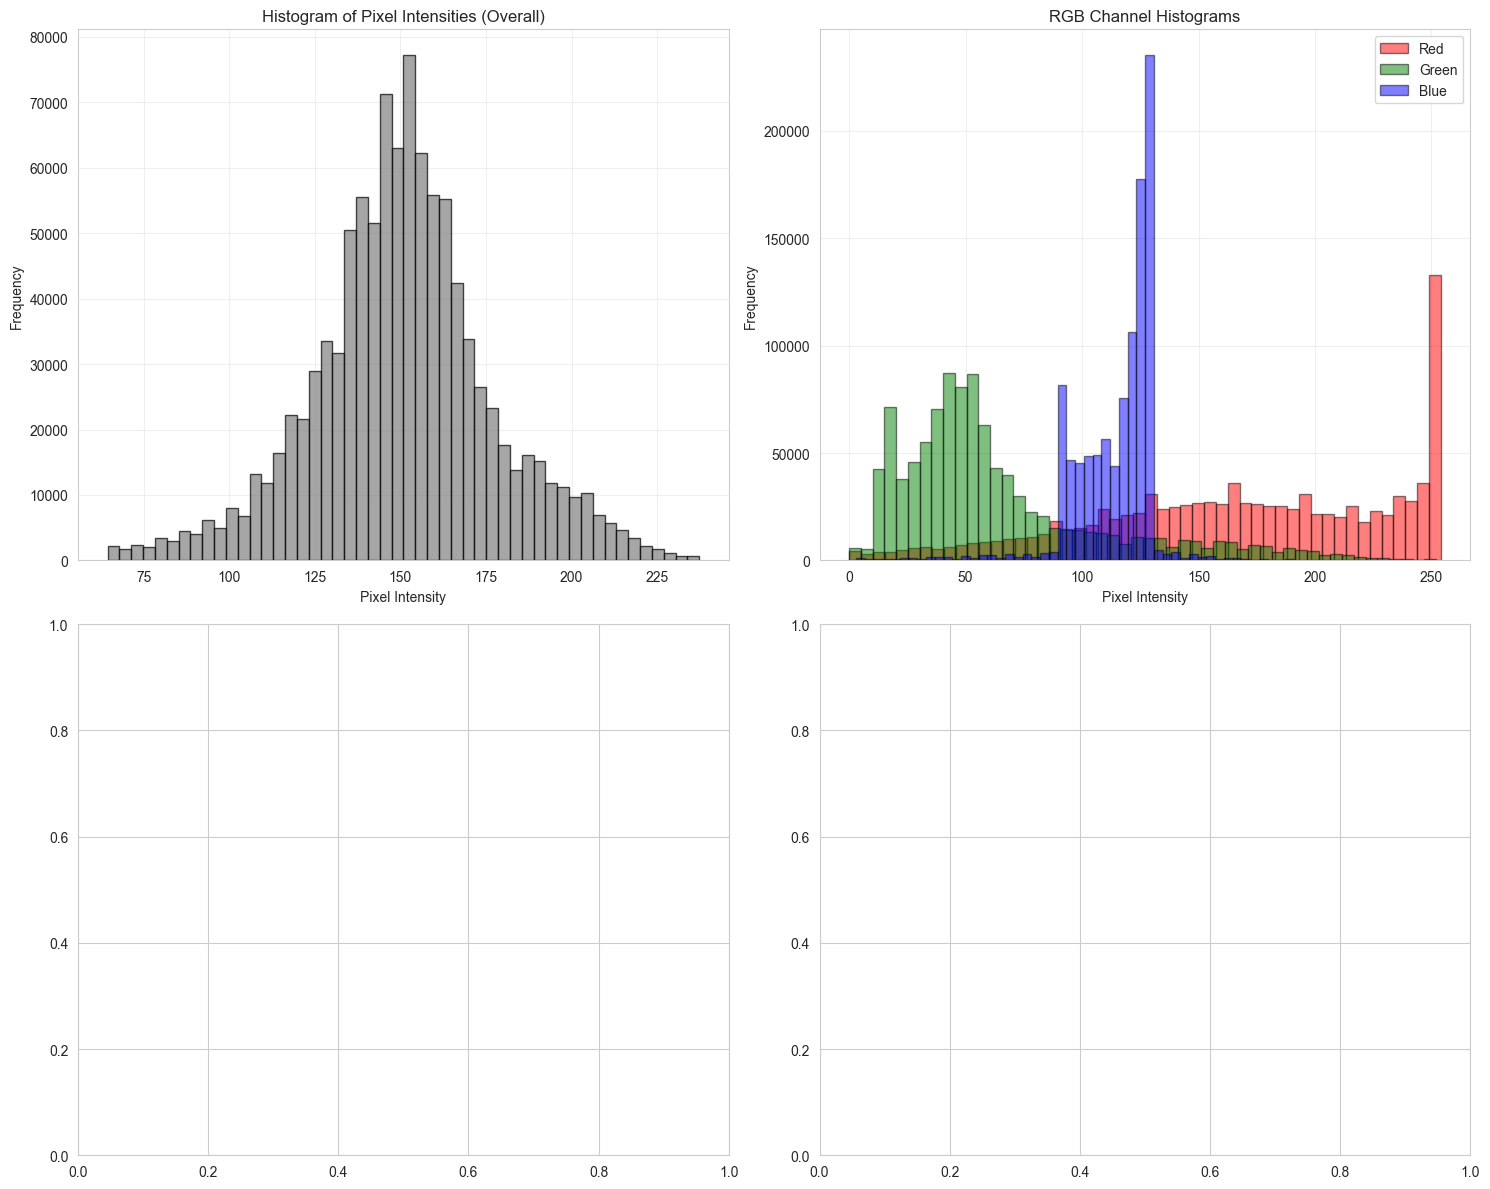

In [38]:
# Visualize spectrogram pixel intensity histograms
if spectrogram_data:
    # Collect all pixel intensities
    all_pixels = []
    rgb_pixels = {'r': [], 'g': [], 'b': []}
    
    for item in spectrogram_data[:100]:  # Sample first 100 for performance
        img_array = item['image']
        if len(img_array.shape) == 3:
            # RGB
            rgb_pixels['r'].extend(img_array[:, :, 0].flatten())
            rgb_pixels['g'].extend(img_array[:, :, 1].flatten())
            rgb_pixels['b'].extend(img_array[:, :, 2].flatten())
            gray = np.mean(img_array, axis=2)
        else:
            gray = img_array
        all_pixels.extend(gray.flatten())
    
    # Plot histograms
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Overall pixel intensity histogram
    axes[0, 0].hist(all_pixels, bins=50, edgecolor='black', alpha=0.7, color='gray')
    axes[0, 0].set_title('Histogram of Pixel Intensities (Overall)')
    axes[0, 0].set_xlabel('Pixel Intensity')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # RGB channel histograms if available
    if rgb_pixels['r']:
        axes[0, 1].hist(rgb_pixels['r'], bins=50, alpha=0.5, label='Red', color='red', edgecolor='black')
        axes[0, 1].hist(rgb_pixels['g'], bins=50, alpha=0.5, label='Green', color='green', edgecolor='black')
        axes[0, 1].hist(rgb_pixels['b'], bins=50, alpha=0.5, label='Blue', color='blue', edgecolor='black')
        axes[0, 1].set_title('RGB Channel Histograms')
        axes[0, 1].set_xlabel('Pixel Intensity')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No RGB data available\n(Grayscale spectrograms)', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('RGB Channel Histograms')
    
    # Pixel intensity by class
    if not spectrogram_stats_df.empty and len(spectrogram_stats_df['label'].unique()) > 1:
        sns.boxplot(data=spectrogram_stats_df, x='label', y='pixel_intensity_mean', 
                   ax=axes[1, 0], palette='muted')
        axes[1, 0].set_title('Mean Pixel Intensity by Class')
        axes[1, 0].set_xlabel('Class')
        axes[1, 0].set_ylabel('Mean Pixel Intensity')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Pixel intensity std by class
    if not spectrogram_stats_df.empty and len(spectrogram_stats_df['label'].unique()) > 1:
        sns.boxplot(data=spectrogram_stats_df, x='label', y='pixel_intensity_std', 
                   ax=axes[1, 1], palette='muted')
        axes[1, 1].set_title('Pixel Intensity Std by Class')
        axes[1, 1].set_xlabel('Class')
        axes[1, 1].set_ylabel('Pixel Intensity Std')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No spectrogram data to visualize")


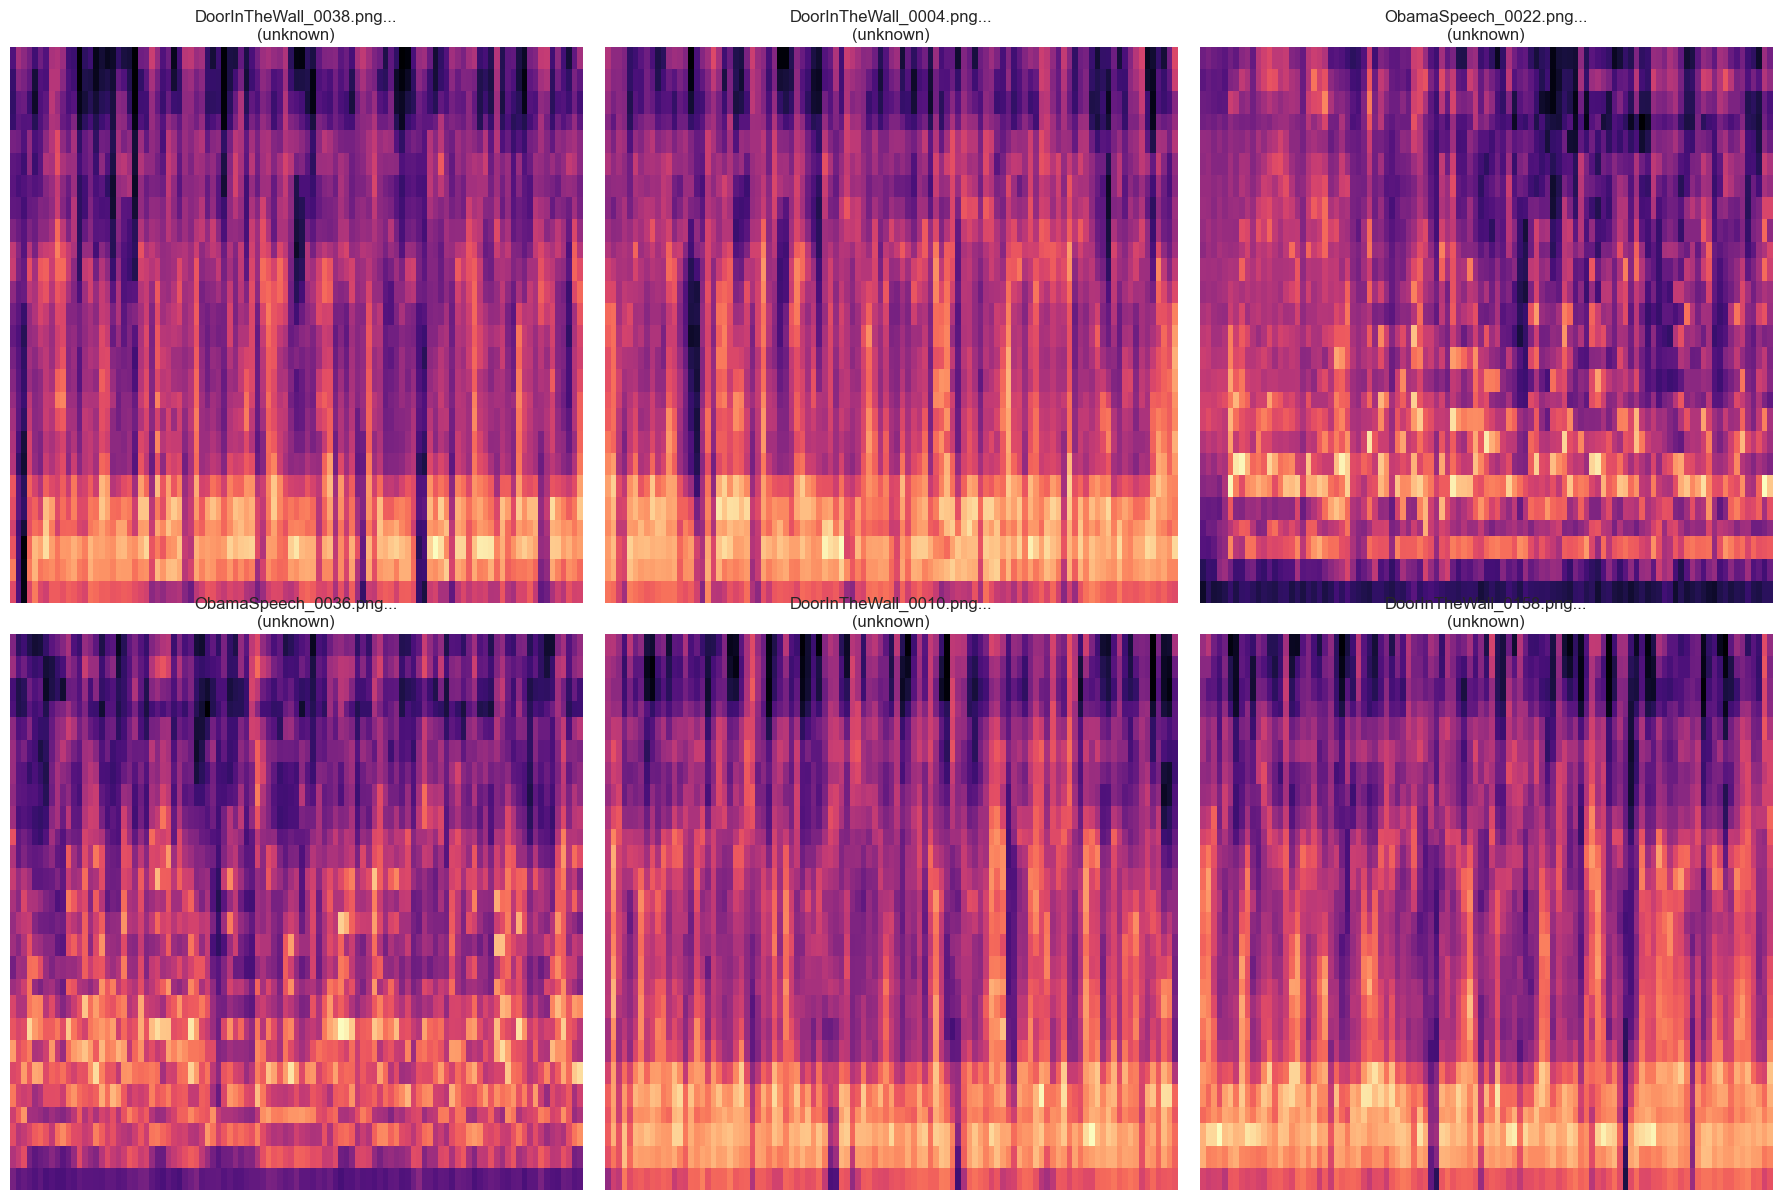

In [39]:
# Display sample spectrograms
if spectrogram_data:
    num_samples = min(6, len(spectrogram_data))
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Get samples from different labels if available
    labels_seen = set()
    samples_to_show = []
    for item in spectrogram_data:
        label = item.get('label', 'unknown')
        if label not in labels_seen or len(samples_to_show) < num_samples:
            samples_to_show.append(item)
            labels_seen.add(label)
        if len(samples_to_show) >= num_samples:
            break
    
    for idx, item in enumerate(samples_to_show):
        if idx < len(axes):
            axes[idx].imshow(item['image'], cmap='viridis' if len(item['image'].shape) == 2 else None)
            axes[idx].set_title(f"{item['file_name'][:30]}...\n({item.get('label', 'unknown')})")
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(samples_to_show), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No spectrogram data to display")
